In [7]:
import nidaqmx
print(nidaqmx.__version__)


1.0.2


In [8]:
with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev2/ai0")
    task.read()
    print ("hola")

hola


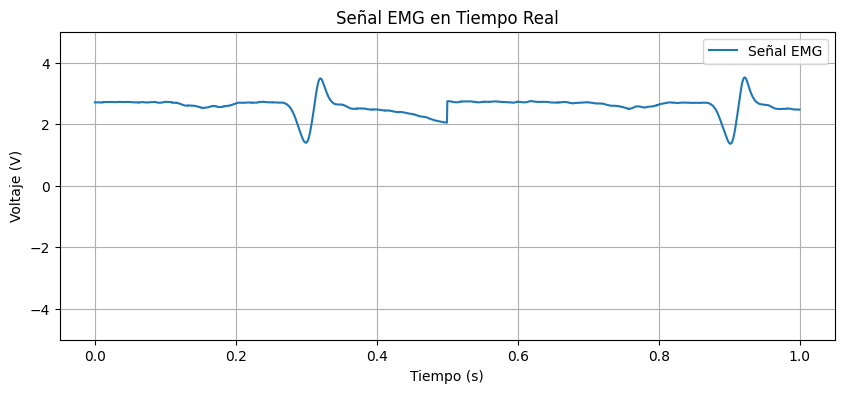

Los datos se han guardado exitosamente en 'emg_data.csv'.


In [9]:
import nidaqmx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import display, clear_output
import csv

# Parámetros de adquisición
puerto= "Dev2/ai0"  # Cambia esto según el canal de tu DAQ
fmuestreo = 2000  # Frecuencia de muestreo en Hz
t_ventana = 2000  # Cantidad de muestras a mostrar en la gráfica
duracion =  300 # Duración de la adquisición en segundos

# Crear estructura de datos para almacenar la señal en tiempo real
emg_buffer = deque([0] * t_ventana, maxlen=t_ventana)  # Guarda los últimos datos capturados
tiempo_buffer = deque(np.linspace(0, (t_ventana - 1) / fmuestreo,t_ventana), maxlen=t_ventana)  # Eje X desde 0

# Archivo de salida para guardar los datos
filename = "emg_data.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Tiempo (s)", "Voltaje (V)"])  # Escribir encabezado

    # Configurar la tarea de adquisición
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan(puerto)
        task.timing.cfg_samp_clk_timing(fmuestreo)

        print("Adquiriendo datos en tiempo real... Presiona 'Ctrl + C' para detener.")

        # Inicializar la figura
        plt.ion()  # Modo interactivo
        fig, ax = plt.subplots(figsize=(10, 4))
        line, = ax.plot(tiempo_buffer, emg_buffer, label="Señal EMG")
        ax.set_xlabel("Tiempo (s)")
        ax.set_ylabel("Voltaje (V)")
        ax.set_title("Señal EMG en Tiempo Real")
        ax.legend()
        ax.grid(True)
        ax.set_ylim([-5, 5])  # Ajuste de voltaje de -1V a 1V

        # Bucle de adquisición en tiempo real
        try:
            total_samples = int(duracion * fmuestreo)
            for i in range(0, total_samples, t_ventana):
                # Leer múltiples muestras a la vez
                emg_data = task.read(number_of_samples_per_channel=t_ventana)

                if isinstance(emg_data, list):  # Confirmar que es una lista
                    emg_buffer.extend(emg_data)

                    # Guardar los datos en el archivo
                    for j in range(len(emg_data)):
                        tiempo = (i + j) / fmuestreo
                        writer.writerow([tiempo, emg_data[j]])

                    # Actualizar gráfico en tiempo real
                    line.set_ydata(emg_buffer)
                    clear_output(wait=True)
                    display(fig)
                    plt.pause(0.01)

        except KeyboardInterrupt:
            print("Adquisición detenida por el usuario.")

        plt.ioff()
        plt.show()

print(f"Los datos se han guardado exitosamente en '{filename}'.")

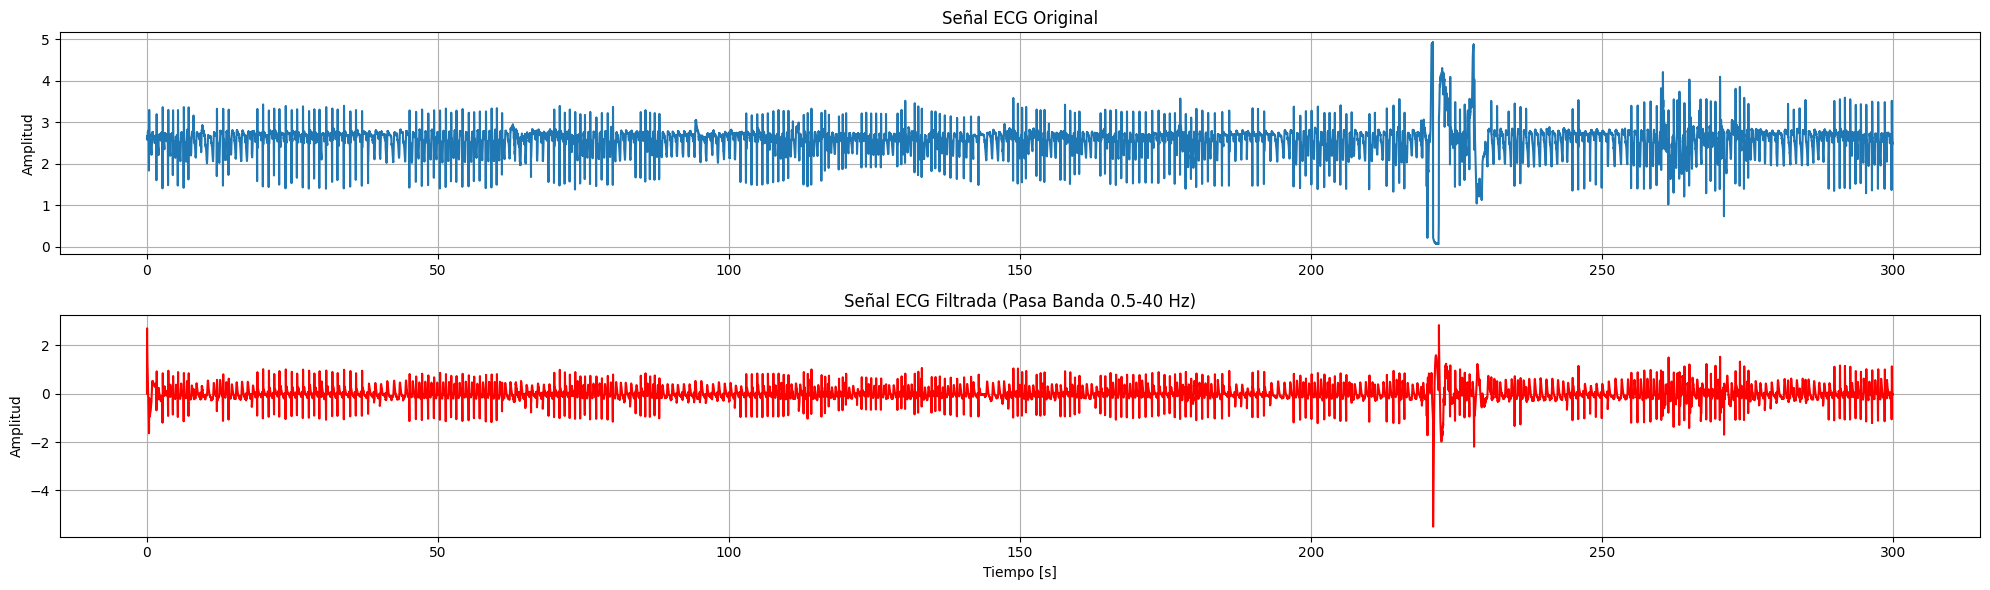

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# --- Cargar señal ---
ruta_csv = 'emg_data.csv'
df = pd.read_csv(ruta_csv)

# Seleccionar segunda columna
ecg_signal = df.iloc[:, 1].values

# --- Parámetros ---
fs = 1000  # Hz
lowcut = 0.5
highcut = 40
order = 4  # Orden del filtro

# --- Filtro digital Butterworth ---
low = lowcut / (fs/2)
high = highcut / (fs/2)

b_d, a_d = butter(order, [low, high], btype='band')

# --- Filtrar la señal ---
ecg_filtered = lfilter(b_d, a_d, ecg_signal)

# --- Graficar ---
t = np.arange(len(ecg_signal)) / fs

plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.plot(t, ecg_signal)
plt.title('Señal ECG Original')
plt.grid()
plt.ylabel('Amplitud')

plt.subplot(2,1,2)
plt.plot(t, ecg_filtered, color='red')
plt.title('Señal ECG Filtrada (Pasa Banda 0.5-40 Hz)')
plt.grid()
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()


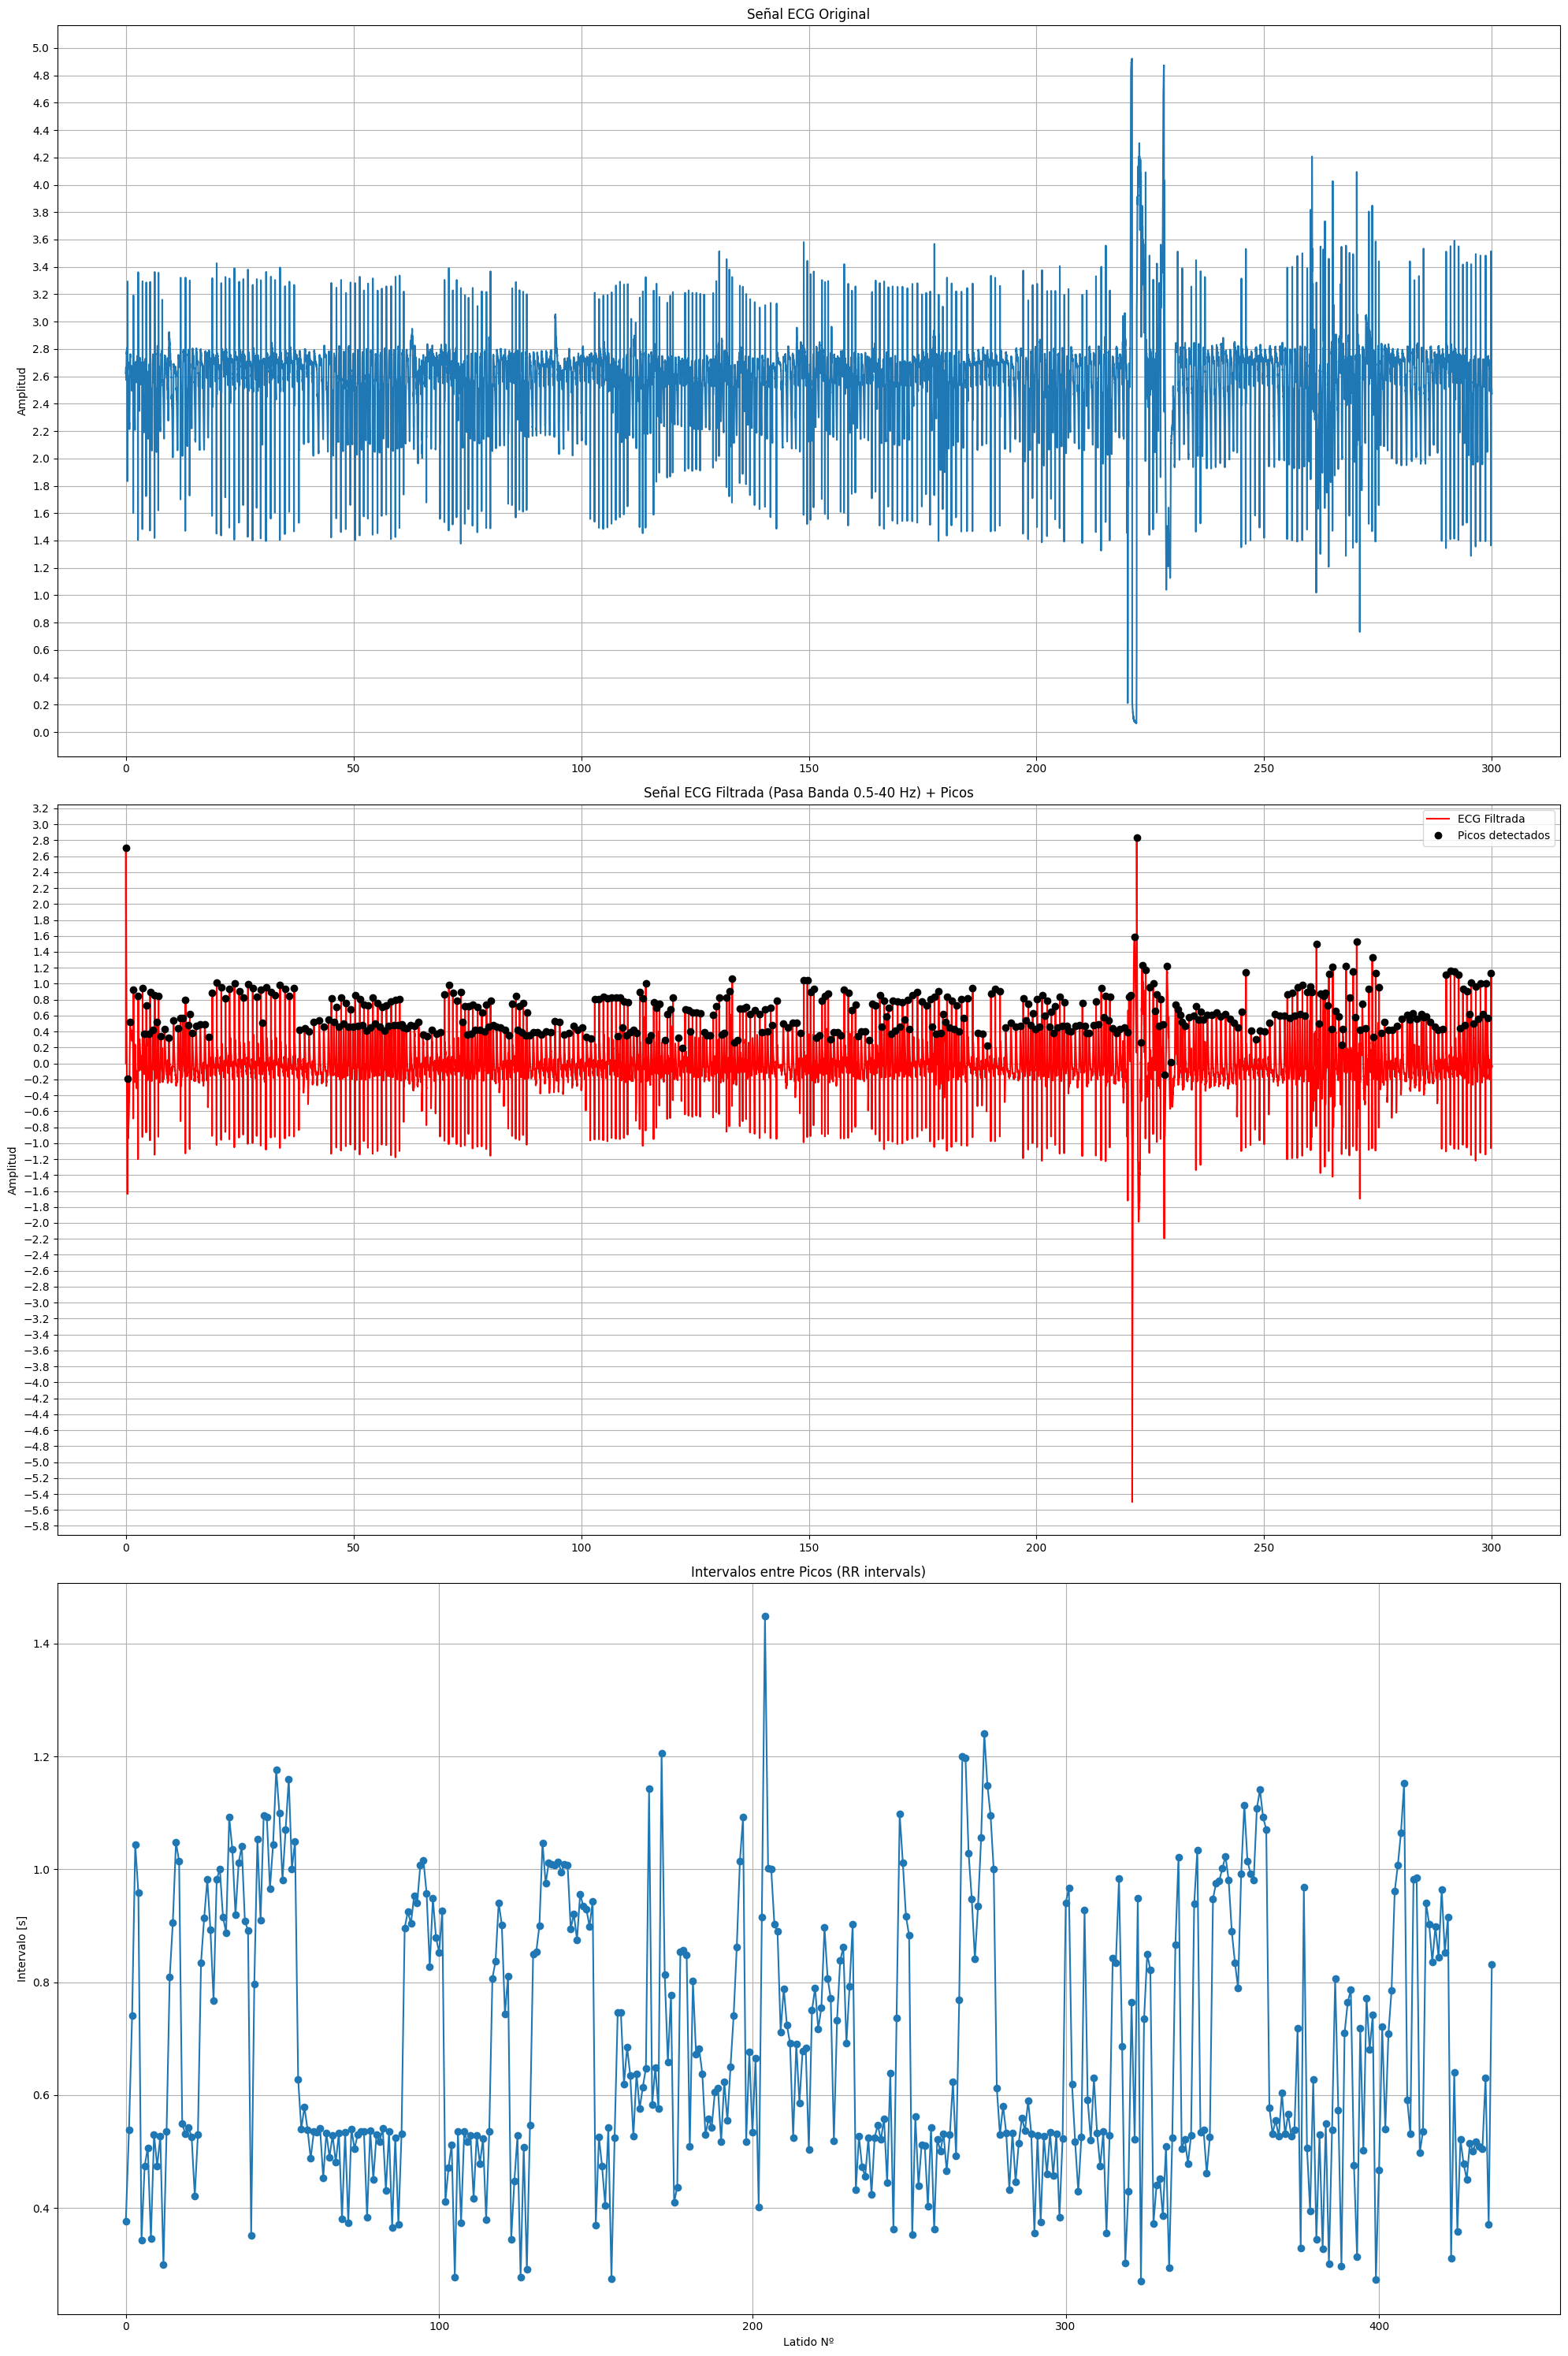

Media de RR (Mean HRV): 0.6861 s
Desviación estándar de RR (std RR): 0.2369 s
SDNN: 0.2369 s
RMSSD: 0.2035 s
pNN50: 72.54%
Media de los intervalos RR (Mean RR): 0.6861 s


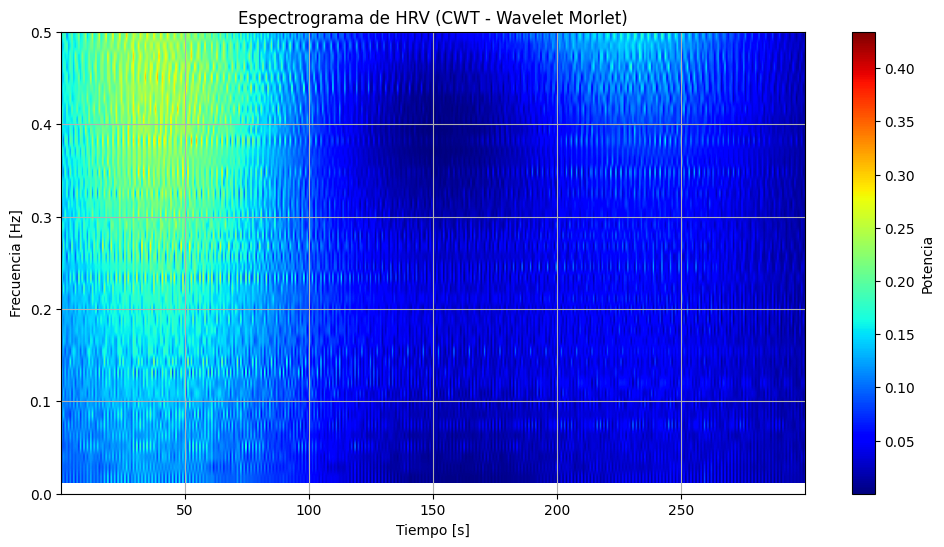

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import matplotlib.ticker as ticker

# --- Cargar señal ---
ruta_csv = 'emg_data.csv'
df = pd.read_csv(ruta_csv)

# Seleccionar segunda columna
ecg_signal = df.iloc[:, 1].values

# --- Parámetros ---
fs = 1000  # Hz
lowcut = 0.5
highcut = 40
order = 4  # Orden del filtro

# --- Filtro digital Butterworth ---
low = lowcut / (fs/2)
high = highcut / (fs/2)

b_d, a_d = butter(order, [low, high], btype='band')

# --- Filtrar la señal ---
ecg_filtered = lfilter(b_d, a_d, ecg_signal)

# --- Detección de picos (ajustada) ---
# Reducimos distancia mínima entre picos para mayor sensibilidad
min_distance = int(0.25 * fs)  # 0.25 segundos (250 ms)
picos, _ = find_peaks(ecg_filtered, distance=min_distance, prominence=0.5)

# --- Calcular intervalos entre picos ---
intervalos = np.diff(picos) / fs  # Diferencias de tiempo en segundos
#print ( intervalos)
# --- Graficar ---
t = np.arange(len(ecg_signal)) / fs

plt.figure(figsize=(20,30))
# Señal original
plt.subplot(3,1,1)
plt.plot(t, ecg_signal)
plt.title('Señal ECG Original')
plt.grid()
plt.ylabel('Amplitud')

ax1 = plt.gca()  # obtener el eje actual
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # ticks cada 0.2

# Señal filtrada con picos detectados
plt.subplot(3,1,2)
plt.plot(t, ecg_filtered, color='red', label='ECG Filtrada')
plt.plot(t[picos], ecg_filtered[picos], 'ko', label='Picos detectados')  # marcar picos
plt.title('Señal ECG Filtrada (Pasa Banda 0.5-40 Hz) + Picos')
plt.grid()
plt.ylabel('Amplitud')
plt.legend()

ax2 = plt.gca()
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

# Vector de intervalos
plt.subplot(3,1,3)
plt.plot(intervalos, marker='o')
plt.title('Intervalos entre Picos (RR intervals)')
plt.grid()
plt.xlabel('Latido Nº')
plt.ylabel('Intervalo [s]')

ax3 = plt.gca()
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

plt.tight_layout()
plt.show()


# --- Cálculos de HRV en el dominio del tiempo ---
# Calcular la media y desviación estándar de los intervalos RR
mean_rr = np.mean(intervalos)  # Media de los intervalos RR
std_rr = np.std(intervalos)    # Desviación estándar de los intervalos RR

# --- A partir de los intervalos RR, calcular la frecuencia instantánea en ppm ---
hr_inst = 60 / intervalos  # vector de frecuencias instantáneas (ppm)

# --- Calcular la frecuencia cardiaca media ---
mean_hr = np.mean(hr_inst)  # frecuencia media (ppm)
# SDNN: Desviación estándar de los intervalos RR
sdnn = np.std(intervalos)

# RMSSD: Raíz cuadrada de la media de las diferencias al cuadrado entre intervalos consecutivos
rmssd = np.sqrt(np.mean(np.diff(intervalos)**2))

# pNN50: Porcentaje de intervalos consecutivos que difieren más de 50 ms
pnn50 = np.sum(np.abs(np.diff(intervalos)) > 0.05) / len(intervalos) * 100

# --- Mostrar resultados por separado ---
print(f"Media de RR (Mean HRV): {mean_rr:.4f} s")
print(f"Desviación estándar de RR (std RR): {std_rr:.4f} s")

# Resultados de HRV:
print(f"SDNN: {sdnn:.4f} s")
print(f"RMSSD: {rmssd:.4f} s")
print(f"pNN50: {pnn50:.2f}%")
print(f"Media de los intervalos RR (Mean RR): {mean_rr:.4f} s") 

import pywt
import numpy as np
import matplotlib.pyplot as plt

# --- RR como señal base para análisis ---
rr_times = np.cumsum(intervalos)  # tiempo relativo de cada latido
rr_signal = intervalos - np.mean(intervalos)  # centramos la señal para análisis

# --- Wavelet CWT ---
# Elección de wavelet biológica y escalas
wavelet = 'cmor1.5-1.0'  # Morlet complejo, buena resolución en tiempo-frecuencia
scales = np.arange(1, 128)  # Escalas para análisis, puede ajustarse

# Aplicar CWT
coef, freqs = pywt.cwt(rr_signal, scales, wavelet, sampling_period=np.mean(intervalos))

# --- Graficar espectrograma (escalograma) ---
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coef)**2, extent=[rr_times[0], rr_times[-1], freqs[-1], freqs[0]],
           cmap='jet', aspect='auto')
plt.colorbar(label='Potencia')
plt.title('Espectrograma de HRV (CWT - Wavelet Morlet)')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.ylim(0, 0.5)  # Frecuencias típicas de HRV
plt.grid(True)
plt.show()
